In [1]:
%load_ext autoreload
%autoreload 2

# RHEED diffraction profiles
This notebook shows how to use xrheed to get a diffraction profile from an RHEED image.

As shown in `getting_sarted` notebook, first we need to load xrheed library and then the RHEED image.

In [2]:
import xrheed
from xrheed.io import load_data

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pathlib import Path

In [3]:
image_dir = Path("example_data")
image_path = image_dir / "Si_111_7x7_112_phi_00.raw"

rheed_image = load_data(image_path, plugin="dsnp_arpes_raw")
print(rheed_image.ri)

<RHEEDAccessor>
  Image shape: (1038, 1388)
  Screen scale: 9.04
  Screen sample distance: 309.20
  Theta angle: 1.00 deg
  Beam Energy: 18600.0 eV



## RHEED data preparation
The RHEED image should be aligned by applying rotation if necessary and moved horizontally and vertically to get the image center in proper place.

In [4]:
# Create a copy of an image
rotated_image = rheed_image.copy()

# Rotate the image
rotated_image.ri.rotate(-0.4)

# Use now the rotated image for further analysis
rheed_image = rotated_image

# Apply automatic center search again after rotation
rheed_image.ri.apply_image_center(auto_center=True)

For convenience setup the region of interest (ROI) and plot the image.

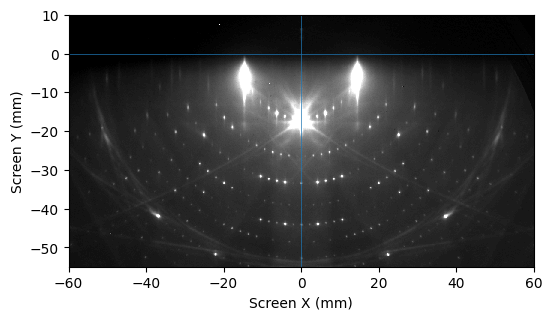

In [5]:
rheed_image.ri.screen_roi_width = 60
rheed_image.ri.screen_roi_height = 55

# Use automatic levels adjustment
rheed_image.ri.plot_image(auto_levels=1.0)
plt.show()

## Profile extraction
Since the RHEED image is stored as an DataArray the profile could be simply taken using build-in `sel` method as shown bellow. However, it is recommended to use a build in accessory to get a profile as shown later.

In [6]:
x_range = (-20, 20)
y_range = (-10, 0)

profile = rheed_image.sel(x=slice(*x_range), y=slice(*y_range)).sum("y")

## Profile extraction using the `get_profile` method
A `get_profile` method in `ri` accesory could be also used to extract a profile by giving the center point, the width and the height.

This funcion can plot a RHEED image with the profile region marked if `plot_origin=True`

D:\workspace\xRHEED\src\xrheed\xarray_accessors.py:20: AccessorRegistrationWarning: registration of accessor <class 'xrheed.xarray_accessors.RHEEDAccessor'> under name 'ri' for type <class 'xarray.core.dataarray.DataArray'> is overriding a preexisting attribute with the same name.
  class RHEEDAccessor:
D:\workspace\xRHEED\src\xrheed\xarray_accessors.py:264: AccessorRegistrationWarning: registration of accessor <class 'xrheed.xarray_accessors.RHEEDProfileAccessor'> under name 'rp' for type <class 'xarray.core.dataarray.DataArray'> is overriding a preexisting attribute with the same name.
  f"  Height: {height} mm\n"


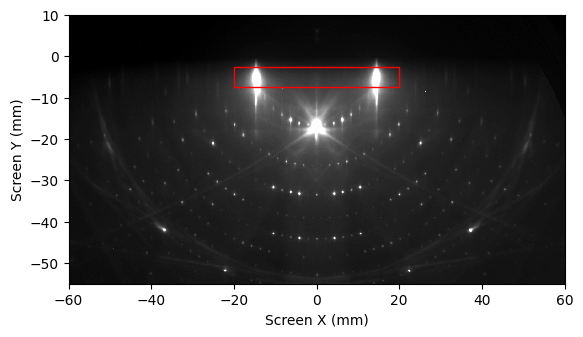

In [11]:
profile = rheed_image.ri.get_profile(center=(0, -5), width=40, height=5,
                                     plot_origin=True)


In [ ]:
profile.rp

A RHEED profile preserves the parent image attributes


In [7]:
profile.ri

<RHEEDAccessor>
  Image shape: (361,)
  Screen scale: 9.04
  Screen sample distance: 309.20
  Theta angle: 1.00 deg
  Beam Energy: 18600.0 eV

## Plot profile function

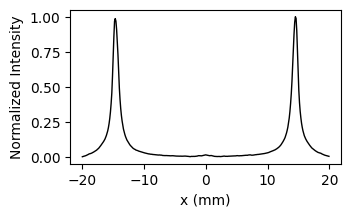

In [8]:
profile.rp.plot_profile(
             transform_to_kx=False,
             normalize=True,
             color="black", linewidth=1.0
             )

plt.show()

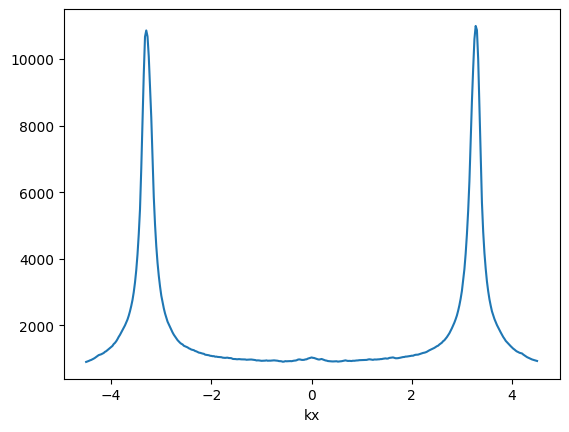

In [ ]:
profile_kx = profile.rp.convert_to_kx()
profile_kx.plot()
plt.show()

## Profile fitting
Profile could be fitted using `lmfit` as shown in an example bellow.

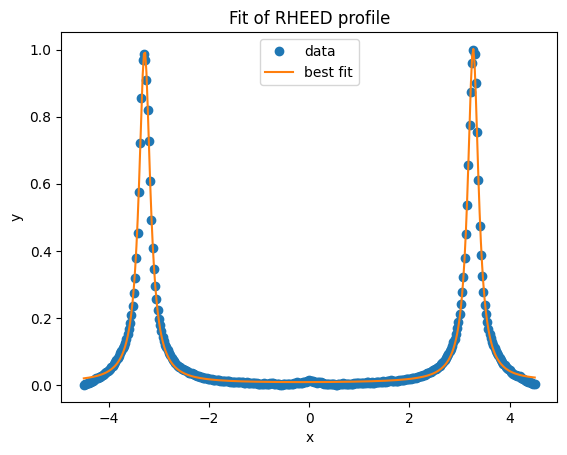

In [ ]:
from lmfit.models import LorentzianModel, QuadraticModel

x = profile_kx.coords["kx"].values
y = profile_kx.values

y = y - np.min(y)  # Remove background offset
y = y / np.max(y)  # Normalize to the maximum value

# Build individual models
l1 = LorentzianModel(prefix='l1_')
l2 = LorentzianModel(prefix='l2_')
bkg = QuadraticModel(prefix='bkg_')

# Create composite model
model = l1 + l2 + bkg

# Initialize parameters
params = model.make_params()

# Provide reasonable initial guesses
params['l1_center'].set(value=-3.0)
params['l1_amplitude'].set(value=1.0)
params['l1_sigma'].set(value=0.1)

params['l2_center'].set(value=3.0)
params['l2_amplitude'].set(value=1.0)
params['l2_sigma'].set(value=0.1)

params['bkg_a'].set(value=-1.0)
params['bkg_b'].set(value=0)
params['bkg_c'].set(value=0)

# Fit
result = model.fit(y, params, x=x)
result.plot_fit(title="Fit of RHEED profile")
plt.show()

In [ ]:
peak_distance = (result.params['l2_center'].value - result.params['l1_center'].value) * 0.5

print(f"Mean peak distance from the specular spot in [1-10] direction: {peak_distance:.2f} 1/A")

expected_distance = 4 * np.pi / 3.84 # Expected distance for Si(111)-(1x1) in [110] direction
print(f"Expected distance: {expected_distance:.2f} 1/A")


Mean peak distance from the specular spot in [1-10] direction: 3.28 1/A
Expected distance: 3.27 1/A


The distance between the two peaks can be used to fine adjustment of the screen scale if the expected distance is different than the measured one.

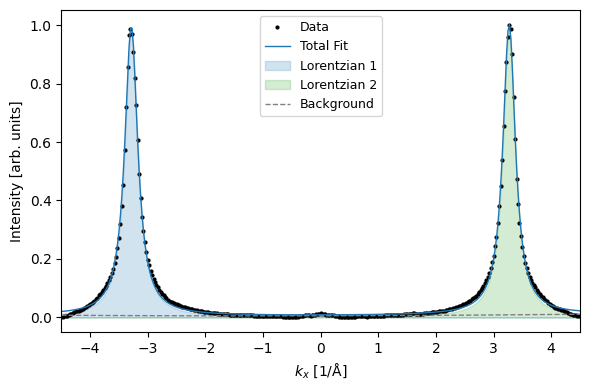

In [ ]:
import matplotlib.pyplot as plt

# Evaluate components
comps = result.eval_components(x=x)

# Create figure
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)

# Plot data and total fit
ax.plot(x, y, 'ko', markersize=2, label="Data")  # black dots for data
ax.plot(x, result.best_fit, color='tab:blue', linestyle='-', linewidth=1, label="Total Fit")

# Plot Lorentzian components as shaded areas
for i, color in zip(range(1, 3), ['tab:blue', 'tab:green', 'tab:purple']):
    comp = comps[f'l{i}_']
    ax.fill_between(x, comp, color=color, alpha=0.2, label=f"Lorentzian {i}")

# Plot background as a dashed line
ax.plot(x, comps['bkg_'], color='gray', linestyle='--', linewidth=1.0, label="Background")

# Labels and styling
ax.set_xlabel("$k_x$ [1/Å]", fontsize=10)
ax.set_ylabel("Intensity [arb. units]", fontsize=10)

# Legend outside the plot area
ax.legend(fontsize=9)
ax.set_xlim(-4.5, 4.5)

plt.show()